# Analysing Sleep Patterns - IoT Project

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
dataset = pd.read_csv('/content/drive/My Drive/ColabNotebooks/Consolidated_data.csv')

In [0]:
dataset.head(5)

,Temperature (Celcius),Humidity %,Light (Lux),Pressure (Pascals),AirQuality (ppb),GyroX (degrees/second),GyroY,GyroZ,AccelerometerX (g's),AccelerometerY,AccelerometerZ,Date (morning after data collection),GMT of Data Reading,Local Time
0,23.43,32.87,0,98966,127,-2.06,2.69,-1.38,-0.02,-0.61,-0.77,3/10/2020,3:59:39 AM,10:59:39 PM
1,23.40,32.76,3,98975,137,-0.19,1.88,-0.31,0.00,0.01,-1.00,3/10/2020,3:59:49 AM,10:59:49 PM
2,23.38,32.38,1,98989,130,-1.56,1.63,0.25,0.00,0.00,-0.98,3/10/2020,3:59:59 AM,10:59:59 PM
3,23.35,32.05,1,98999,127,-4.25,-1.63,-1.00,-0.03,0.01,-0.97,3/10/2020,4:00:10 AM,11:00:10 PM
4,23.29,32.13,3,98949,128,-1.50,1.88,0.25,-0.04,0.03,-0.97,3/10/2020,4:00:19 AM,11:00:19 PM


In [0]:
dataset = dataset.drop(dataset.columns[[8,9,10,12]],axis=1)

In [0]:
dataset.columns = ['Temperature','Humidity','Light','Pressure','Air_quality','Gyrox','Gyroy','Gyroz','Date','Time']

In [0]:
dataset = dataset[['Date','Time','Temperature','Humidity','Light','Pressure','Air_quality','Gyrox','Gyroy','Gyroz']]

In [0]:
dataset.head(5)

,Date,Time,Temperature,Humidity,Light,Pressure,Air_quality,Gyrox,Gyroy,Gyroz
0,3/10/2020,10:59:39 PM,23.43,32.87,0,98966,127,-2.06,2.69,-1.38
1,3/10/2020,10:59:49 PM,23.40,32.76,3,98975,137,-0.19,1.88,-0.31
2,3/10/2020,10:59:59 PM,23.38,32.38,1,98989,130,-1.56,1.63,0.25
3,3/10/2020,11:00:10 PM,23.35,32.05,1,98999,127,-4.25,-1.63,-1.00
4,3/10/2020,11:00:19 PM,23.29,32.13,3,98949,128,-1.50,1.88,0.25


Gyrometers gives the angles relative to its initial orientaion

Dropping the dates on which sensors didnt work

In [0]:
dataset.shape

(46030, 10)

In [0]:
indexNames = dataset[(dataset['Date']=='3/10/2020')|
                    (dataset['Date']=='3/13/2020') |
                    (dataset['Date']=='3/14/2020') |
                    (dataset['Date']=='3/19/2020') |
                    (dataset['Date']=='3/22/2020') |
                    (dataset['Date']=='3/23/2020') |
                    (dataset['Date']=='3/26/2020') |
                    (dataset['Date']=='3/29/2020') |
                    (dataset['Date']=='3/31/2020')].index

dataset.drop(indexNames, inplace = True)

In [0]:
dataset.shape

(27026, 10)

In [0]:
### Defining user defined functions to get the angle of rotation by gyroscope readings

## angle of rotation between two 3D vectors

# https://www.analyzemath.com/stepbystep_mathworksheets/vectors/vector3D_angle.html

def row_vector(row_number):
    return [dataset.Gyrox.values[row_number],dataset.Gyroy.values[row_number],dataset.Gyroz.values[row_number]]

def unit_vector(row_number):
    vector = row_vector(row_number)
    return vector / np.linalg.norm(vector)

def angle_of_rotation(row_number):
    try:
        v1_u = unit_vector(row_number)
        previous_row_number = row_number-1
        v2_u = unit_vector(previous_row_number)
        return round(np.arccos(np.dot(v2_u, v1_u)),3)
        
    except IndexError:
        return None

In [0]:
dataset = dataset.reset_index(drop=True)

In [0]:
dataset['angle_of_rotation'] = dataset.apply(lambda row: angle_of_rotation(row.name),axis = 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in arccos
  


In [0]:
print(len(dataset[dataset['angle_of_rotation'] == 0]))

128


In [0]:
dataset.isna().sum()

Date                  0
Time                  0
Temperature           0
Humidity              0
Light                 0
Pressure              0
Air_quality           0
Gyrox                 0
Gyroy                 0
Gyroz                 0
angle_of_rotation    37
dtype: int64

In [0]:
dataset = dataset.dropna()

In [0]:
dataset.shape

(26989, 11)

Dropping columns - Date, Time, Gyrox, Gyroy, Gyroz

In [0]:
cleaned_dataset = dataset.drop(dataset.columns[[0,1,7,8,9]], axis =1)

In [0]:
cleaned_dataset.head(5)

,Temperature,Humidity,Light,Pressure,Air_quality,angle_of_rotation
0,24.51,35.04,0,98837,143,2.744
1,24.55,34.97,0,98867,148,1.964
2,24.54,34.79,0,98845,150,0.599
3,24.51,34.93,0,98864,150,1.259
4,24.49,34.61,0,98864,150,2.327


In [0]:
cleaned_dataset.dtypes

Temperature          float64
Humidity             float64
Light                  int64
Pressure               int64
Air_quality            int64
angle_of_rotation    float64
dtype: object

### Machine Learning models

In [0]:
# Splitting the Data set
# Defining X and y variables

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(cleaned_dataset, test_size=0.20)

features = ['Temperature','Humidity','Light','Pressure',
            'Air_quality','angle_of_rotation']
df_train = df_train[features]
df_test = df_test[features]

X_train, y_train = df_train.drop('angle_of_rotation',axis=1), df_train['angle_of_rotation']
X_test, y_test = df_test.drop('angle_of_rotation',axis=1), df_test['angle_of_rotation']

In [0]:
## Fitting Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)

rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

In [0]:
print('Training Score: {:.2f} \nValidation Score: {:.2f}'.format(rf.score(X_train, y_train),
                                                                         rf.score(X_test, y_test)))


Training Score: 0.89 
Validation Score: 0.28


### Feature importance by Permutation in Random Forest


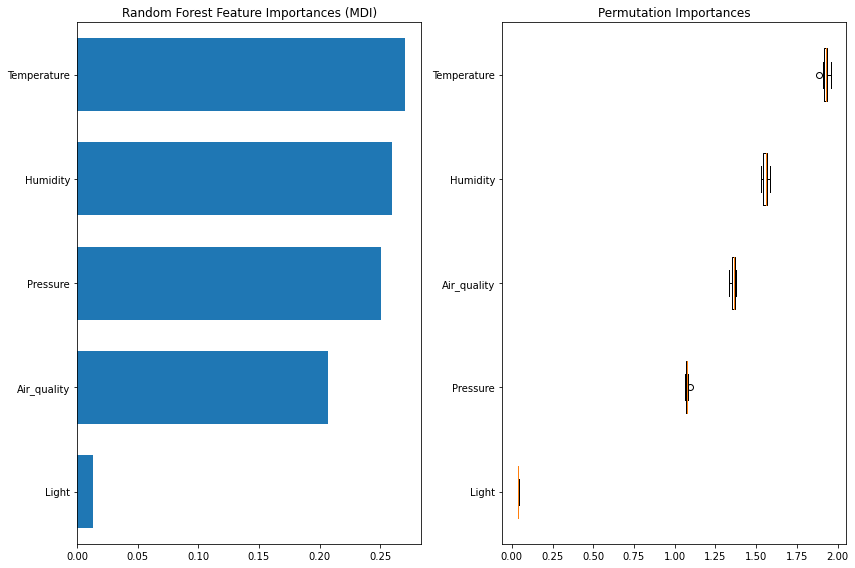

In [0]:
# Understanding the difference betweeen default feature importance by RF and permutation importances

# https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e


from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_train, y_train, n_repeats=10,
                                random_state=42)

perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(rf.feature_importances_)
tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         rf.feature_importances_[tree_importance_sorted_idx], height=0.7)

ax1.set_yticklabels(X_test.columns[tree_importance_sorted_idx])

ax1.set_yticks(tree_indices)

ax1.set_ylim((0, len(rf.feature_importances_)))
ax1.set_title("Random Forest Feature Importances (MDI)")

ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X_test.columns[perm_sorted_idx])
ax2.set_title("Permutation Importances")

fig.tight_layout()
plt.show()
